In [12]:
import os
import json
import torch
import pandas as pd
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    GenerationConfig,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)
from typing import Iterable

import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

device = "cuda"

## Training

In [2]:
train_grouped_tokenized_ratings = load_from_disk("train_grouped_tokenized_ratings")

In [3]:
checkpoint = "HuggingFaceTB/SmolLM-135M"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token
# for fp16 use `torch_dtype=torch.float16` instead
model = AutoModelForCausalLM.from_pretrained(checkpoint, torch_dtype=torch.bfloat16).to(device)

tokenizer_config.json:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [4]:
training_args = TrainingArguments(output_dir="finetuning", report_to="none", remove_unused_columns=False)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [5]:
trainer = Trainer(
    model=model,
    args=training_args,
    # train_dataset=train_tokenized_ratings,
    train_dataset=train_grouped_tokenized_ratings,
    data_collator=data_collator,
)

In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [7]:
trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.870300
1000,0.798000
1500,0.796800
2000,0.795600
2500,0.794900
3000,0.794300
3500,0.794600
4000,0.793900
4500,0.794700
5000,0.794300


TrainOutput(global_step=5250, training_loss=0.8022974562872024, metrics={'train_runtime': 2057.8608, 'train_samples_per_second': 20.41, 'train_steps_per_second': 2.551, 'total_flos': 3425698676736000.0, 'train_loss': 0.8022974562872024, 'epoch': 3.0})

In [9]:
trainer.model.save_pretrained("finetuning_2")

In [9]:
model = AutoModelForCausalLM.from_pretrained("finetuning/checkpoint-5000", torch_dtype=torch.bfloat16).to(device)

In [20]:
x = [{"step": 500, "loss": 2}, {"step": 500, "loss": 2}]
a, b = (zip(*[(s["step"], s["loss"]) for s in x]))
a, b

((500, 500), (2, 2))

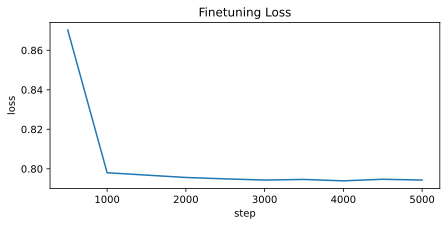

In [28]:
def plot_loss(output_dir: str) -> None:
    latest_checkpoint = max(
        dir_name for dir_name in os.listdir("finetuning")
        if "checkpoint" in dir_name
    )
    
    with open(
        os.path.join(
            output_dir,
            latest_checkpoint,
            "trainer_state.json"
        )
    ) as f:
        trainer_state = json.load(f)
        log_history = trainer_state["log_history"]
        
    steps, losses = zip(*[(s["step"], s["loss"]) for s in log_history])
        
    fig, ax = plt.subplots(1, 1, figsize=(7, 3))
    ax.plot(steps, losses)
    ax.set_xlabel("step")
    ax.set_ylabel("loss")
    ax.set_title("Finetuning Loss")
    

plot_loss("finetuning")

## Inference

In [10]:
generation_config = GenerationConfig(
    max_length=200,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

inputs = tokenizer.encode("Recommend movie for user_id 892", return_tensors="pt").to(device)
outputs = model.generate(inputs, generation_config=generation_config)
print(tokenizer.decode(outputs[0]))

Recommend movie for user_id 892 user_id 285 movie_id 1006 user_id 287 movie_id 1006 user_id 285 movie_id 1006 user_id 285 user_id 285 movie_id 1006 user_id 285 movie_id 1006 user_id 285 movie_id 1006 user_id 285 movie_id 1006 user_id 285 movie_id 1006 user_id 285 movie_id 1006 user_id 285 movie_id 1006 user_id 285 movie_id 1006 user_id 285 movie_id 1006 user_id
